In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

#from utils.helper import fn_plot_tf_hist

In [3]:
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:
###----------------------
### Some basic parameters
###----------------------


inpDir = 'C:/Users/Administrator.DAI-PC2/Documents/DNN/input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 100 # number of cycles to run
PATIENCE = 20
LR_PATIENCE = 10
FACTOR_LR = 0.1
BATCH_SIZE = 32 # inline of Training Rows being 60000
IMG_HEIGHT = 190 #may vary
IMG_WIDTH = 190


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
print (physical_devices)

[]


Delete these lines

In [8]:
# labels = []
# for count, data in enumerate (train_ds):
#     imgs, lbls = data
#     #print(count, ':', imgs.shape, lbls.shape)
#     labels.append(lbls)
# tf.concat(labels,axis=0).numpy().shape
# unique, A, counts = tf.unique_with_counts(tf.concat(labels,axis=0).numpy())
# unique, A, counts

In [9]:
def fn_plot_label(tr_ds, ts_ds):  # def plot
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels code explained above

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts code explained above

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [10]:
'''import pathlib -> remove comments if working on colab
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''


data_dir = os.path.join(inpDir, subDir)
data_dir

'C:/Users/Administrator.DAI-PC2/Documents/DNN/input\\flower_photos'

In [11]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [12]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [14]:
class_dict = {k: v for k,v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [15]:
num_classes = len(class_names)
num_classes

5

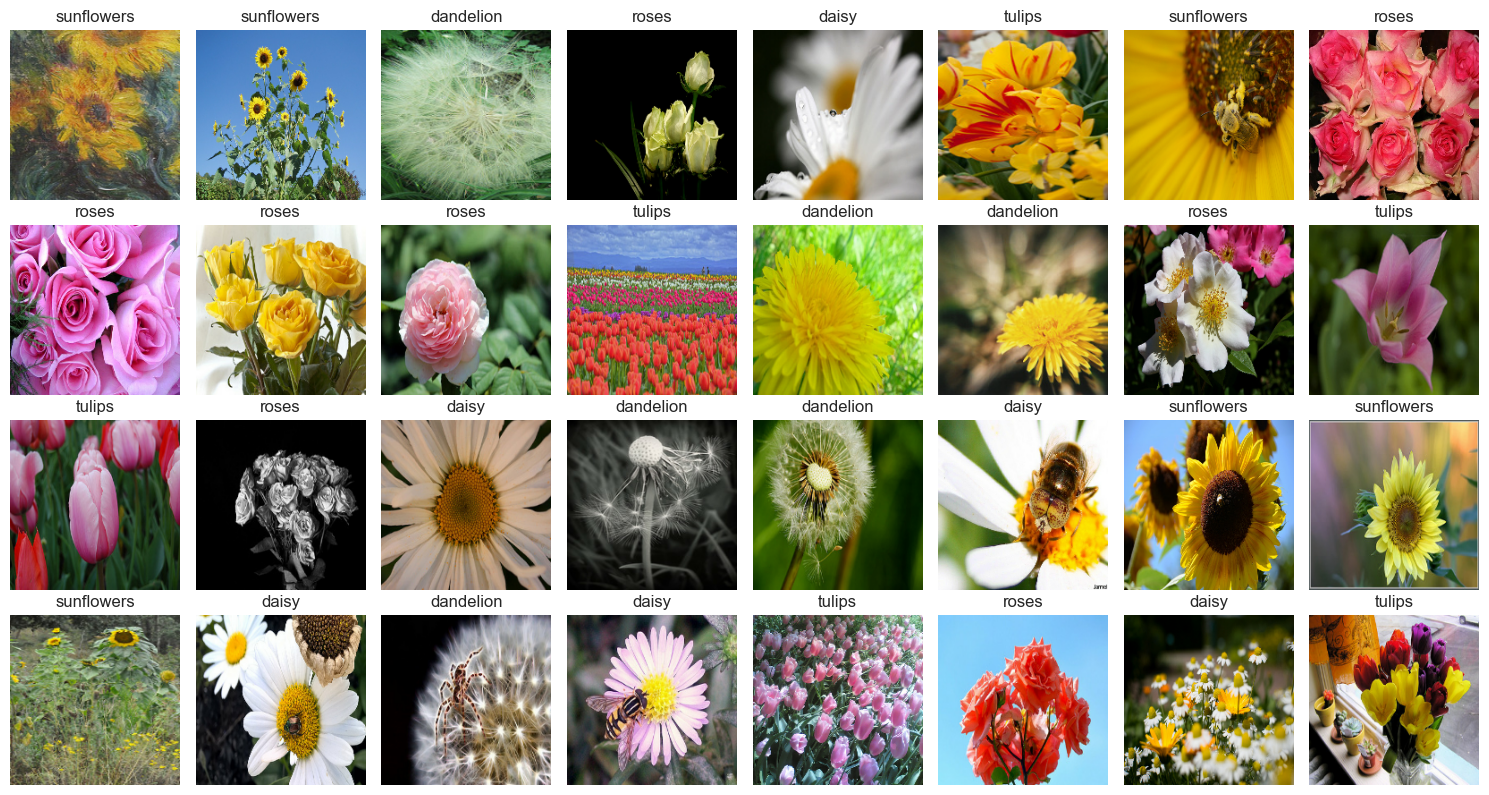

In [16]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

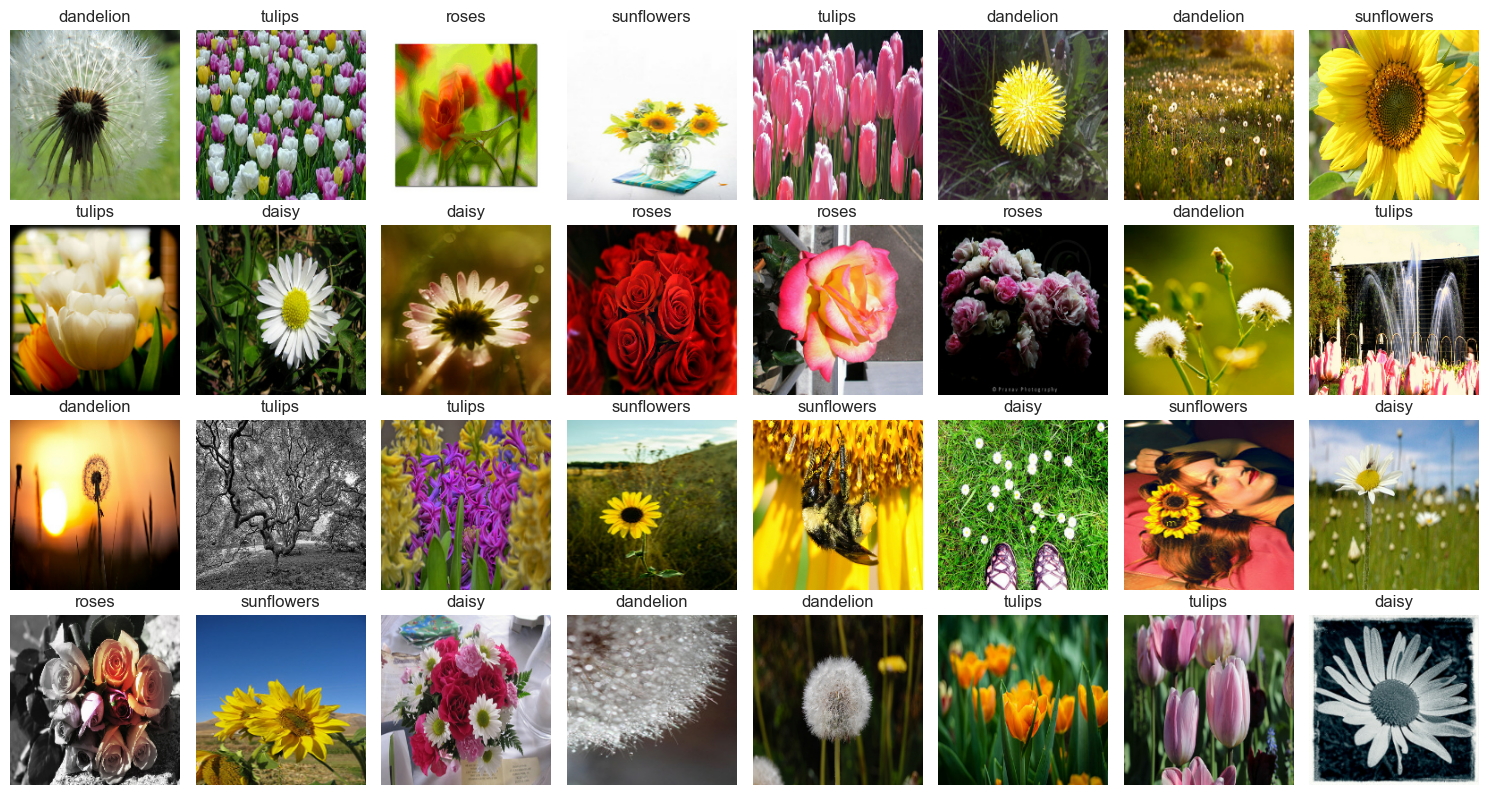

In [17]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch
    
    for i in range (BATCH_SIZE): # loop over batch
        
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        
        plt.grid(False) # no to grid
        
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
    
    plt.tight_layout()

plt.show()

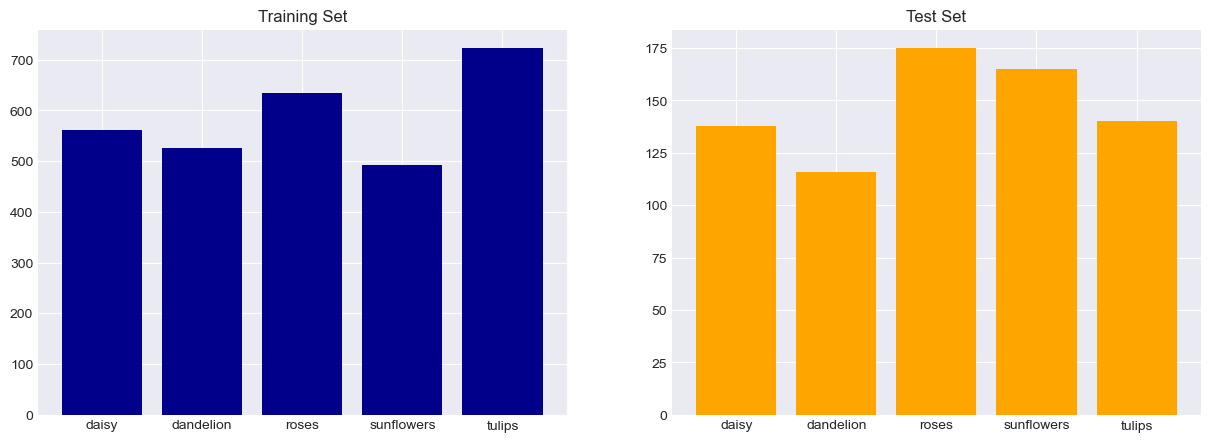

In [18]:
fn_plot_label(train_ds, test_ds)

In [ ]:
train_ds= train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(190, 190, 3)

In [34]:
def build_model(input_shape, num_classes):
    kernel_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

    model = tf.keras.Sequential()

#Pre-processing
    model.add(tf.keras.layers.Rescaling(1./255.))
    
    #Augmentation Layers here!

#Set 1
#Convolution 1
    model.add(tf.keras.layers.Conv2D(32,(3,3),
    kernel_initializer = kernel_init,
    activation='relu',
    input_shape=input_shape)   #o/p--> 188 x 188 x 32
)

    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p---> 94 x 945 x 32

#Set 2
#Convolution 2
    model.add(tf.keras.layers.Conv2D(64,(3,3),
    kernel_initializer = kernel_init,
    activation='relu')   #o/p--> 92 x92 x 64
)

    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p---> 46 x 46 x 64

#Set 3
#Convolution 3
    model.add(tf.keras.layers.Conv2D(128,(3,3),
    kernel_initializer = kernel_init,
    activation='relu')   #o/p--> 44x 44 x 128
)

    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p--->22 x 22 x 128

#Set 4
#Convolution 4
    model.add(tf.keras.layers.Conv2D(256,(3,3),
    kernel_initializer = kernel_init,
    activation='relu')   #o/p--> 20 x 20 x 256
)

    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p---> 10 x 10 x 256

#Set 5
#Convolution 5
    model.add(tf.keras.layers.Conv2D(512,(3,3),
    kernel_initializer = kernel_init,
    activation='relu')   #o/p--> 8 x 8x 512
)

    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p---> 4 x 4 x 32

#Set 6
#Convolution 6
    model.add(tf.keras.layers.Conv2D(1024,(3,3),
    kernel_initializer = kernel_init,
    activation='relu')   #o/p--> 2 x 2 x 1024
)
    
#Head
    model.add(tf.keras.layers.Flatten())

#Dense 1
    model.add(tf.keras.layers.Dense(1024, kernel_initializer=kernel_init,activation= 'relu'))

#Dense 2
    model.add(tf.keras.layers.Dense(64, kernel_initializer=kernel_init,activation= 'relu'))

#Dense 3
    model.add(tf.keras.layers.Dense(num_classes))

    return model

In [35]:
model = build_model(input_shape,num_classes)
model

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
#Model callback
checkpoint_path=os.path.join(modelDir,subDir,'Fashion_cnn')

model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

#EarlyStopping callback
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=2,
    baseline=None,
    restore_best_weights=True
)

#Lr
lr_callback=tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=FACTOR_LR,
                patience=LR_PATIENCE,
                verbose=1
            )

In [42]:
history= model.fit(train_ds,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   callbacks=[model_checkpoint_callback,
                              es_callback,lr_callback],
                   validation_data=test_ds)

Epoch 1/100


92/92 [==============================] - ETA: 0s - loss: 1.5216 - accuracy: 0.2933
Epoch 1: val_loss improved from inf to 1.35338, saving model to ../models\flower_photos\Fashion_cnn
92/92 [==============================] - 57s 572ms/step - loss: 1.5216 - accuracy: 0.2933 - val_loss: 1.3534 - val_accuracy: 0.3896 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 1.2627 - accuracy: 0.4584
Epoch 2: val_loss improved from 1.35338 to 1.13217, saving model to ../models\flower_photos\Fashion_cnn
92/92 [==============================] - 51s 550ms/step - loss: 1.2627 - accuracy: 0.4584 - val_loss: 1.1322 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.5688
Epoch 3: val_loss improved from 1.13217 to 0.99018, saving model to ../models\flower_photos\Fashion_cnn
92/92 [==============================] - 51s 550ms/step - loss: 1.0669 - accuracy: 0.5688 - val_loss: 0.9902 - val_

92/92 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9983
Epoch 26: val_loss did not improve from 0.78542
92/92 [==============================] - 50s 544ms/step - loss: 0.0044 - accuracy: 0.9983 - val_loss: 1.9196 - val_accuracy: 0.7439 - lr: 1.0000e-04
Epoch 27/100
92/92 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9993
Epoch 27: val_loss did not improve from 0.78542
92/92 [==============================] - 50s 545ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 2.0187 - val_accuracy: 0.7466 - lr: 1.0000e-04
Epoch 28/100
92/92 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993
Epoch 28: val_loss did not improve from 0.78542
92/92 [==============================] - 50s 542ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 2.1046 - val_accuracy: 0.7425 - lr: 1.0000e-04
Epoch 29/100
92/92 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993
Epoch 29: val_loss did not improve fro

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 94, 94, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       7

In [47]:
# tf.keras.utils.plot_model(model,'model.png',
#                         show_shapes=True,
#                          show_dtype=True,
#                          dpi=96,
#                          show_layer_activations=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


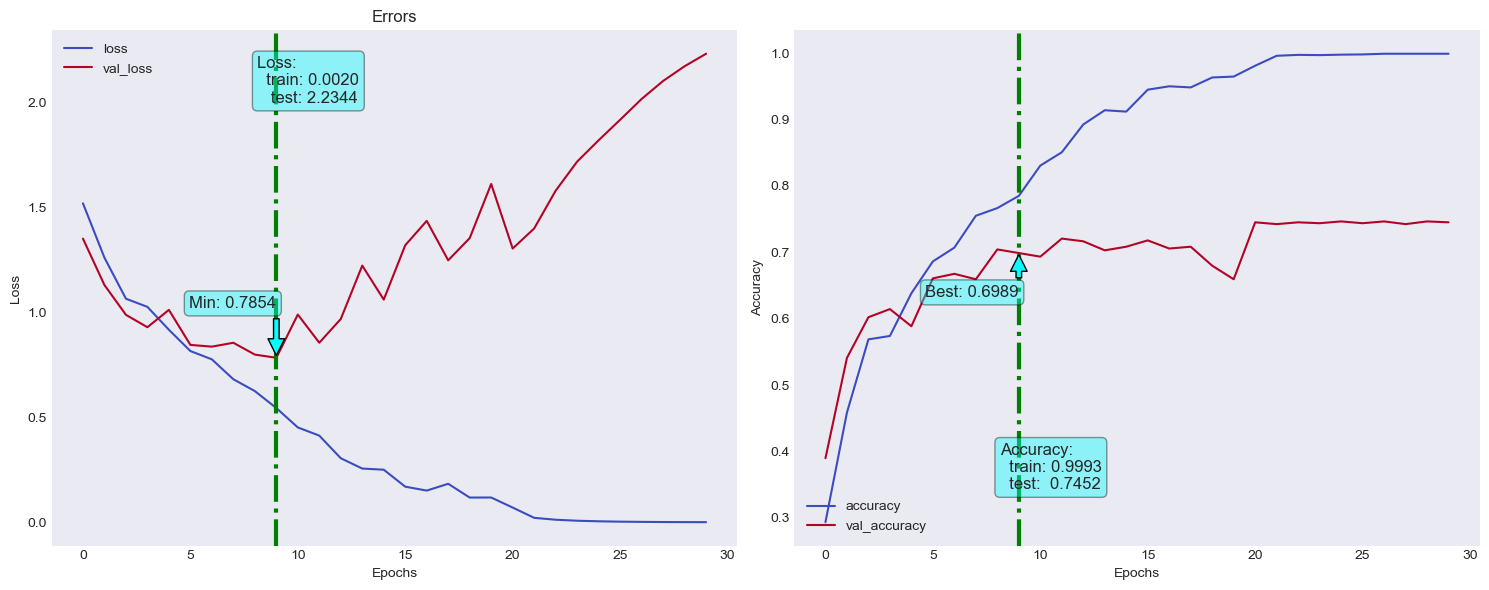

In [43]:
 fn_plot_tf_hist(pd.DataFrame(history.history))

# Data Augmentation 

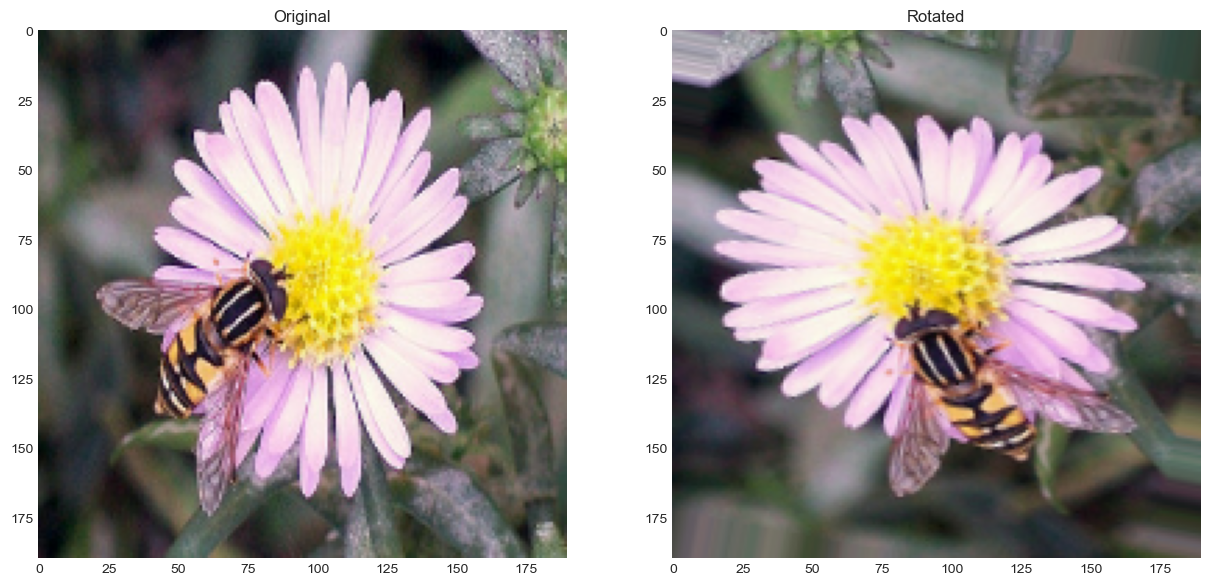

In [55]:
layer= tf.keras.layers.RandomRotation((-0.5,0.5),fill_mode='nearest',seed=RANDOM_STATE)

plt.figure()

img_num=0
for images, labels in train_ds.take(1):
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('Original')
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)
    
    plt.subplot(1,2,2)
    plt.title('Rotated')
    plt.imshow(out_images[img_num].numpy().astype('uint16'))
    plt.grid(False)